In [1]:
import numpy as np
from tictactoe import TicTacToe
import matplotlib.pyplot as plt

In [2]:
class Player:
    def __init__(self, num_actions, gamma, learning_rate, epsilon) -> None:
        self.qfunction = {}
        self._gamma = gamma
        self._alpha = learning_rate
        self._epsilon =  epsilon
        self._num_actions = num_actions
    
    def act(self, state, eval = False):
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)
        Q_s = self.qfunction[state].copy()
        if (eval or np.random.uniform() > self._epsilon) and np.any(Q_s - Q_s[0]):
            action = np.argmax(self.qfunction[state])
        else :
            action = np.random.randint(self._num_actions)
        return action
    

    def update(self, state, action, next_state, reward, done) -> None:
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)
        
        if done:
            self.qfunction[state][action] = (1-self._alpha) * self.qfunction[state][action] + self._alpha * reward
        else:
            if next_state not in self.qfunction:
                self.qfunction[next_state] = np.zeros(self._num_actions)
            self.qfunction[state][action] = (1-self._alpha) * self.qfunction[state][action] + self._alpha * (reward + self._gamma * self.qfunction[next_state].max()) 


In [3]:
def run_episode(player1, player2, environment, eval, max_step = 100):
    state = environment.reset()
    n_steps = 0
    player = [player1, player2]
    rewards = [0,0]
    dones = [False, False]
    p = 0
    winners = []
    while True:
        action = player[p].act(state, eval=eval)
        next_state, reward, done, switch = environment.step(action)
        
        if not eval:
            player[p].update(state, action, next_state, reward, done)
        rewards[p] += reward
        dones[p] = done
        if done:
            winners.append(p+1)
        n_steps += 1
        state = next_state
        if all(dones) or n_steps > max_step:
            break
        if switch: # do not pass the hand until player put in an empty place
            p = int(not p) 
    winner = winners[0] if winners else 0
    return rewards, winner

In [39]:
environment = TicTacToe()
player1 = Player(environment.num_actions, gamma=1, learning_rate=0.01, epsilon= .9)
player2 = Player(environment.num_actions, gamma=1, learning_rate=0.01, epsilon= .9)

num_episodes = 20000
eval_every_N = 10 
num_eval_episodes = 10

max_step = 100

all_rewards = []
episodes = []

print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")
try:
  for episode in range(num_episodes):
    run_episode(player1, player2, environment, eval=False, max_step = max_step)

    if episode % eval_every_N == 0:
      rewards = np.mean([run_episode(player1, player2, environment, eval=True, max_step = max_step)[0] for _ in range(num_eval_episodes)], axis=-1)
      print(f"\t{episode}\t|\t{rewards[0]:.2f} vs {rewards[1]:.2f}")
      all_rewards.append(rewards)
      episodes.append(episode)
except KeyboardInterrupt:
  pass

all_rewards = np.array(all_rewards).T

Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	-3.50 vs -5.50
	10	|	-9.00 vs -7.00
	20	|	-4.50 vs -8.50
	30	|	-6.00 vs -6.00
	40	|	-8.00 vs -20.50
	50	|	-0.50 vs -0.50
	60	|	-7.00 vs -5.50
	70	|	-5.00 vs -3.00
	80	|	-16.00 vs -47.00
	90	|	-48.50 vs -5.50
	100	|	-1.50 vs -3.50
	110	|	0.00 vs -49.00
	120	|	-0.50 vs -1.00
	130	|	-15.50 vs -1.00
	140	|	-0.50 vs 0.00
	150	|	-3.50 vs -6.50
	160	|	-0.50 vs -4.00
	170	|	-3.00 vs -1.50
	180	|	-1.00 vs -4.00
	190	|	-10.00 vs -1.00
	200	|	-48.50 vs -2.50
	210	|	-0.50 vs -8.00
	220	|	-47.00 vs -1.50
	230	|	-49.50 vs -2.50
	240	|	-9.00 vs -22.50
	250	|	-4.50 vs -49.50
	260	|	-49.50 vs 0.00
	270	|	-9.50 vs -9.50
	280	|	-49.00 vs -47.50
	290	|	-49.50 vs -49.50
	300	|	-2.50 vs -2.00
	310	|	-46.50 vs -49.50
	320	|	-3.50 vs -5.50
	330	|	-49.00 vs -15.50
	340	|	-4.00 vs -48.50
	350	|	-49.00 vs -48.50
	360	|	-7.00 vs -3.50
	370	|	-2.00 vs -3.00
	380	|	-49.50 vs -48.00
	390	|	-49.00 vs -48.5

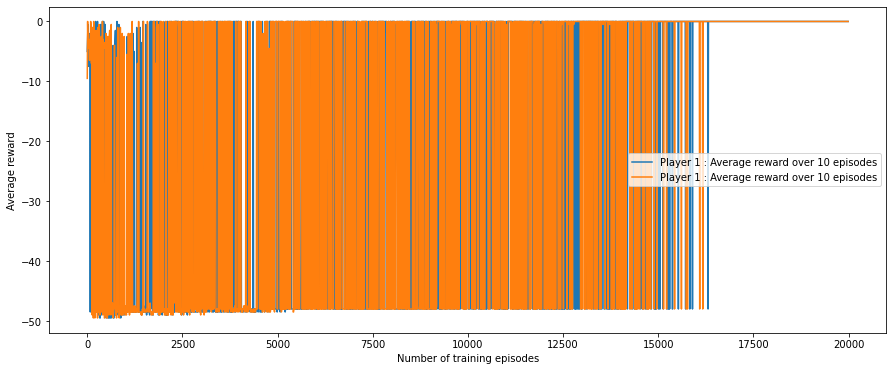

In [20]:
plt.figure(figsize=(15, 6))
plt.xlabel('Number of training episodes')
plt.ylabel('Average reward')
plt.plot(episodes, all_rewards[0], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")
plt.plot(episodes, all_rewards[1], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")

plt.legend()

In [37]:
P1 = player1.qfunction
P2 = player2.qfunction

In [38]:
state = list(P1.keys())[20]
qvalue = P1[state].copy()
state, qvalue

('121122102', array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [32]:
qvalue += qvalue.min()
qvalue[np.array(map(int, list(state))) != 0] = 0

state, qvalue

('121122102', array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
Policy = { state: qvalue[np.array()] for state, qvalue in P1.items()}